In [1]:
pip install python_binance

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.9/69.9 kB 893.5 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.2/53.2 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.2/130.2 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 18.6 MB/s eta 0:00:00


In [3]:
from binance import Client, ThreadedWebsocketManager, ThreadedDepthCacheManager

Конечный баланс: $9973.35
Общая доходность: -0.27%
Процент прибыльных сделок: 16.67%
Средняя прибыль за сделку: 0.78%
Средний убыток за сделку: -1.81%
Медианная прибыль за сделку: 0.78%
Медианный убыток за сделку: -1.80%


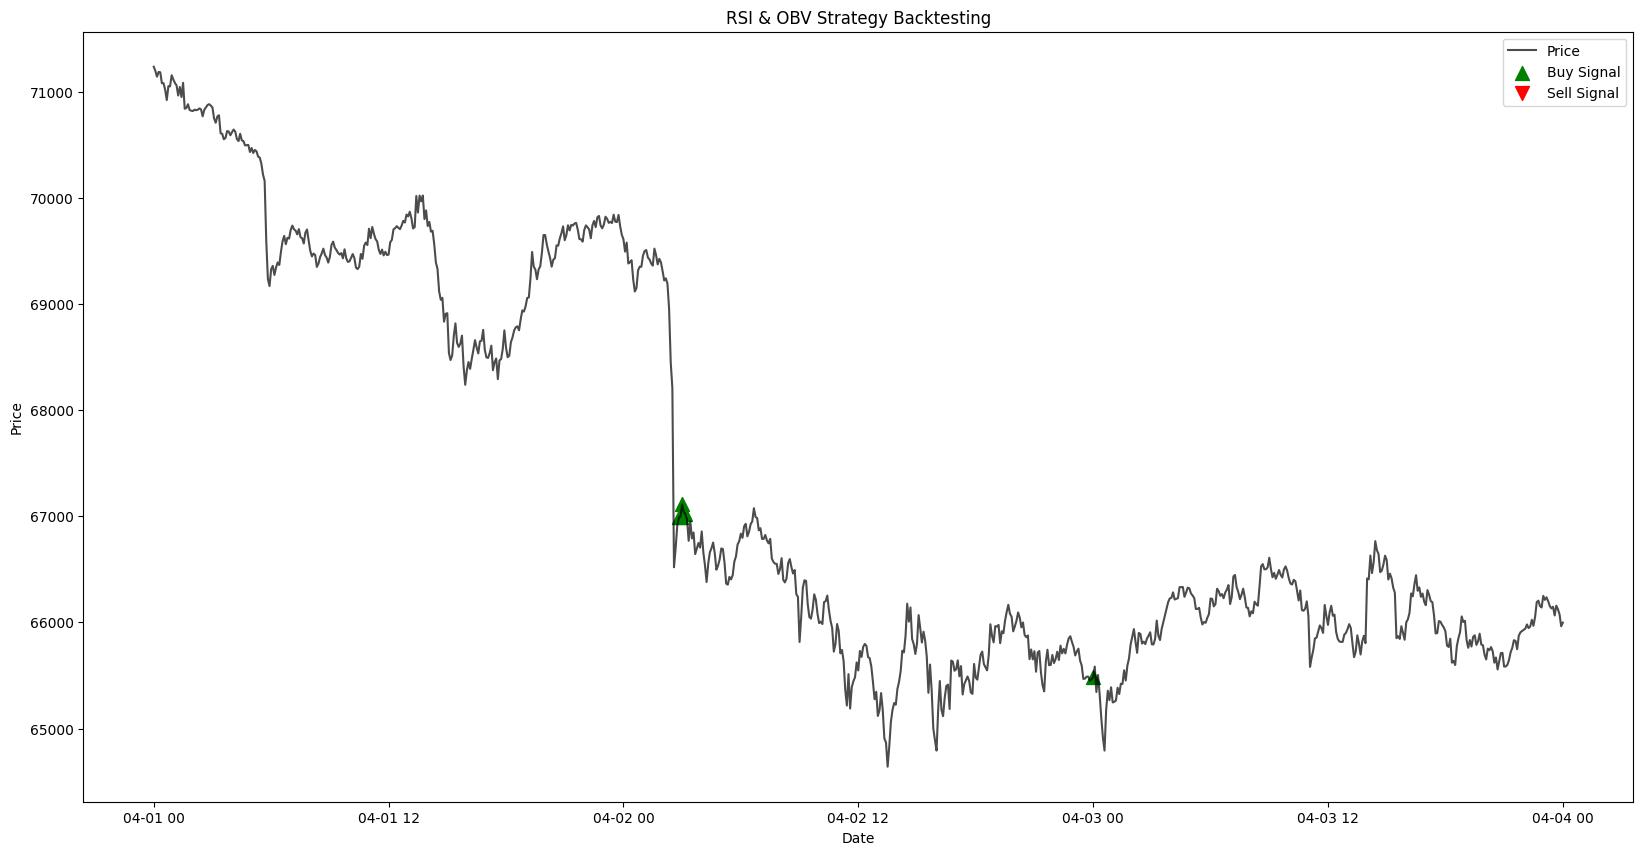

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from binance import Client
from datetime import timedelta

client = Client(api_key='', api_secret='')

symbol = 'BTCUSDT'
interval = Client.KLINE_INTERVAL_5MINUTE

# Получение исторических данных с Binance
def get_historical_ohlcv(symbol, interval, start_str=None, end_str=None, limit=1000):
    klines = client.get_historical_klines(symbol, interval, start_str, end_str, limit=limit)
    df = pd.DataFrame(klines, columns=[
        'timestamp', 'open', 'high', 'low', 'close', 'volume',
        'close_time', 'quote_av', 'trades', 'tb_base_av', 'tb_quote_av', 'ignore'
    ])
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
    df.set_index('timestamp', inplace=True)
    df = df[['open', 'high', 'low', 'close', 'volume']].astype(float)
    return df

df = get_historical_ohlcv(symbol, interval, "1 Apr, 2024", "4 Apr, 2024")

def calculate_rsi(series, period=14):
    delta = series.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=period).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=period).mean()
    rs = gain / loss
    return 100 - (100 / (1 + rs))

df['RSI'] = calculate_rsi(df['close'])

def calculate_obv(df):
    obv = [0]
    for i in range(1, len(df)):
        if df['close'].iloc[i] > df['close'].iloc[i - 1]:
            obv.append(obv[-1] + df['volume'].iloc[i])
        elif df['close'].iloc[i] < df['close'].iloc[i - 1]:
            obv.append(obv[-1] - df['volume'].iloc[i])
        else:
            obv.append(obv[-1])
    df['OBV'] = obv
    df['OBV_EMA'] = df['OBV'].ewm(span=20).mean()
    return df

df = calculate_obv(df)

def strategy(row):
    if row['RSI'] < 25 and row['OBV'] > row['OBV_EMA']:
        return 1  # Buy
    elif row['RSI'] > 75 and row['OBV'] < row['OBV_EMA']:
        return -1  # Sell
    return 0  # Neutral

df['Signal'] = df.apply(strategy, axis=1)

def collect_trades(df, commission=0.001):
    cash = 10000  # Начальный баланс
    positions = []  # Список открытых позиций (цена, количество, время)
    max_position_time = timedelta(weeks=2)  # Максимальное время позиции
    trade_percent = 0.03  # Процент от текущего баланса для одной сделки
    stop_loss_percent = 0.015  # Стоп-лосс 1.5%
    take_profit_percent = 0.03  # Тейк-профит 3%
    trades = []  # Список всех сделок
    max_open_positions = 5  # Максимальное количество открытых позиций

    def close_position(entry_price, current_price, position_size, reason, current_time):
        nonlocal cash
        cash += position_size * current_price * (1 - commission)
        profit = (current_price - entry_price) / entry_price * 100
        trades.append({'type': 'sell', 'price': current_price, 'profit': profit, 'reason': reason, 'time': current_time})

    for i in range(1, len(df)):
        current_time = df.index[i]
        signal = df.iloc[i]['Signal']
        price = df.iloc[i]['close']

        # Проверяем стоп-лосс, тейк-профит и ограничение по времени каждой открытой позиции
        new_positions = []
        for entry_price, entry_time, position_size in positions:
            if price <= entry_price * (1 - stop_loss_percent):
                close_position(entry_price, price, position_size, 'stop_loss', current_time)
            elif price >= entry_price * (1 + take_profit_percent):
                close_position(entry_price, price, position_size, 'take_profit', current_time)
            elif current_time - entry_time > max_position_time:
                close_position(entry_price, price, position_size, 'time_limit', current_time)
            else:
                new_positions.append((entry_price, entry_time, position_size))
        positions = new_positions

        if signal == 1 and len(positions) < max_open_positions:  # Buy
            trade_amount = cash * trade_percent  # Используем текущий баланс
            position_size = (trade_amount * (1 - commission)) / price
            positions.append((price, current_time, position_size))
            trades.append({'type': 'buy', 'price': price, 'time': current_time})

        elif signal == -1 and positions:  # Sell
            # Закрываем первую позицию, которую можем закрыть безопасно
            entry_price, entry_time, position_size = positions.pop(0)
            close_position(entry_price, price, position_size, 'signal', current_time)

    # Если остались открытые позиции, закрываем их по последней цене
    for entry_price, entry_time, position_size in positions:
        close_position(entry_price, df.iloc[-1]['close'], position_size, 'end', df.index[-1])

    return trades

def calculate_final_balance(initial_balance, trades, commission=0.001):
    cash = initial_balance
    positions = []

    for trade in trades:
        if trade['type'] == 'buy':
            price = trade['price']
            trade_amount = cash * 0.03
            position_size = (trade_amount * (1 - commission)) / price
            positions.append((price, position_size))
            cash -= trade_amount
        elif trade['type'] == 'sell':
            entry_price, position_size = positions.pop(0)
            cash += position_size * trade['price'] * (1 - commission)

    return cash

initial_balance = 10000
trades = collect_trades(df)
final_balance = calculate_final_balance(initial_balance, trades)

profitable_trades = [trade for trade in trades if trade['type'] == 'sell' and trade['profit'] > 0]
unprofitable_trades = [trade for trade in trades if trade['type'] == 'sell' and trade['profit'] <= 0]

win_rate = len(profitable_trades) / len([t for t in trades if t['type'] == 'sell']) * 100 if trades else 0
total_return = (final_balance - initial_balance) / initial_balance * 100
avg_profit = np.mean([trade['profit'] for trade in profitable_trades]) if profitable_trades else 0
avg_loss = np.mean([trade['profit'] for trade in unprofitable_trades]) if unprofitable_trades else 0

# Рассчитываем медианную прибыль для прибыльных сделок
median_profit = np.median([trade['profit'] for trade in trades if trade['type'] == 'sell' and trade['profit'] > 0]) if profitable_trades else 0

# Рассчитываем медианный убыток для убыточных сделок
median_loss = np.median([trade['profit'] for trade in trades if trade['type'] == 'sell' and trade['profit'] <= 0]) if unprofitable_trades else 0

print(f'Конечный баланс: ${final_balance:.2f}')
print(f'Общая доходность: {total_return:.2f}%')
print(f'Процент прибыльных сделок: {win_rate:.2f}%')
print(f'Средняя прибыль за сделку: {avg_profit:.2f}%')
print(f'Средний убыток за сделку: {avg_loss:.2f}%')
print(f'Медианная прибыль за сделку: {median_profit:.2f}%')
print(f'Медианный убыток за сделку: {median_loss:.2f}%')

plt.figure(figsize=(20, 10))
plt.plot(df['close'], color='black', alpha=0.7, label='Price')
plt.scatter(df.index[df['Signal'] == 1], df['close'][df['Signal'] == 1], marker='^', color='green', s=100, label='Buy Signal')
plt.scatter(df.index[df['Signal'] == -1], df['close'][df['Signal'] == -1], marker='v', color='red', s=100, label='Sell Signal')
plt.legend()
plt.title('RSI & OBV Strategy Backtesting')
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

In [25]:
print(trades)
print(final_balance)
print(len(trades))

[{'type': 'buy', 'price': 66988.52, 'time': Timestamp('2024-04-02 02:50:00')}, {'type': 'buy', 'price': 66996.0, 'time': Timestamp('2024-04-02 02:55:00')}, {'type': 'buy', 'price': 67111.99, 'time': Timestamp('2024-04-02 03:00:00')}, {'type': 'buy', 'price': 67040.4, 'time': Timestamp('2024-04-02 03:05:00')}, {'type': 'buy', 'price': 67018.99, 'time': Timestamp('2024-04-02 03:10:00')}, {'type': 'sell', 'price': 65815.03, 'profit': -1.7517777672950607, 'reason': 'stop_loss', 'time': Timestamp('2024-04-02 09:00:00')}, {'type': 'sell', 'price': 65815.03, 'profit': -1.7627470296734151, 'reason': 'stop_loss', 'time': Timestamp('2024-04-02 09:00:00')}, {'type': 'sell', 'price': 65815.03, 'profit': -1.9325309829137927, 'reason': 'stop_loss', 'time': Timestamp('2024-04-02 09:00:00')}, {'type': 'sell', 'price': 65815.03, 'profit': -1.8278083066330084, 'reason': 'stop_loss', 'time': Timestamp('2024-04-02 09:00:00')}, {'type': 'sell', 'price': 65815.03, 'profit': -1.7964460520816656, 'reason': 's